# Exploratory data analysis and figures for the presentation

In [ ]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

from IPython.display import FileLink,Audio

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

os.chdir(r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier')
print(os.getcwd())


In [ ]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

def RAVDESS_extractor(audio_dir):
    data_list = []
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    RAV_metadata_df = pd.DataFrame(columns = columns)
    
    # Map identifiers to their corresponding values
    emotion_dict = {
      "01": "neutral", "02": "neutral", "03": "happy", "04": "sad",
      "05": "angry", "06": "fear", "07": "disgust", "08": "surprised"
    }
    
    intensity_dict = {"01": "medium", "02": "high"}
    statement_dict = {"01": "Kids are talking by the door", "02": "Dogs are sitting by the door"}
    
    
    data_list = []
    for actor_folder in os.listdir(audio_dir):
      actor_path = os.path.join(audio_dir, actor_folder)
    
      if os.path.isdir(actor_path):  # Check if it's a folder
            for file in os.listdir(actor_path):
                if file.endswith(".wav"):
                    parts = file.split(".")[0].split("-") #first split the .wav extension then the '-'
    
                    # Extract metadata from the filename
                    modality = parts[0]  # Not used, as it’s audio-only for now
                    vocal_channel = "speech" if parts[1] == "01" else "song"
                    emotion = emotion_dict[parts[2]]
                    emotional_intensity = intensity_dict[parts[3]]
                    statement = statement_dict[parts[4]]
                    actor_id = int(parts[6])
                    gender = "male" if actor_id % 2 != 0 else "female"
                    file_path = os.path.join(actor_path, file)  # Full path to the file
                    
                    # Append to datalist (ignoring the repetition)
                    data_list.append({
                        'Filename': file,
                        'Filepath':file_path,
                        'Gender': gender,
                        'Emotion': emotion,
                        'Emotional Intensity': emotional_intensity
                    })
    
    df_addon = pd.DataFrame(data_list)
    RAV_metadata_df = pd.concat([RAV_metadata_df, df_addon], ignore_index=True)

    return RAV_metadata_df

def CREMA_extractor(audio_dir,crema_metadata_df):
    data_list = []
    emotion_map_dict = {'SAD':'sad',
                       'ANG':'angry',
                       'DIS':'disgust',
                       'FEA':'fear',
                       'HAP':'happy',
                       'NEU':'neutral'}
    intensity_dict = {'LO':'low',
                     'MD':'medium',
                     'HI':'high',
                     'XX':'unknown',
                     'X':'unknown'}

    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    crema_organized_df = pd.DataFrame(columns = columns)
    
    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        actor_id = int(parts[0])

        gender = crema_metadata_df.loc[crema_metadata_df['ActorID'] == actor_id]['Sex'].values[0].lower()
        emotion = emotion_map_dict[parts[2]]

        #debugging
        #print(file_name)
        intensity = intensity_dict[parts[3]]

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    crema_organized_df = pd.concat([crema_organized_df,df_addon],ignore_index=True)
    return crema_organized_df

def SAVEE_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    savee_metadata_df = pd.DataFrame(columns = columns)

    data_list = []
    
    emotion_map_dict = {'sa':'sad',
                       'a':'angry',
                       'd':'disgust',
                       'f':'fear',
                       'h':'happy',
                       'n':'neutral',
                        'su':'surprised'}

    for file in os.listdir(audio_dir):
        parts = file.split('.')[0].split('_')

        file_name = file
        file_path = os.path.join(audio_dir,file)
        gender = 'male'
        
        emotion_code = "".join([s for s in parts[1] if s.isalpha()])
        emotion = emotion_map_dict[emotion_code]
        intensity = 'unknown'

        data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    savee_metadata_df = pd.concat([savee_metadata_df,df_addon],ignore_index=True)
    return savee_metadata_df

def TESS_extractor(audio_dir):
    columns = ['Filename','Filepath','Gender','Emotion','Emotional Intensity']
    tess_metadata_df = pd.DataFrame(columns = columns)
    
    emotion_map_dict = {'sad':'sad',
                       'angry':'angry',
                       'disgust':'disgust',
                       'fear':'fear',
                       'happy':'happy',
                       'neutral':'neutral',
                       'ps':'surprised'}
    data_list = []
    
    for folder in os.listdir(audio_dir):
      folder_path = os.path.join(audio_dir, folder)
    
      if os.path.isdir(folder_path):  # Check if it's a folder
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_name = file
                    file_path = os.path.join(folder_path, file)
                    
                    parts = file.split('.')[0].split('_')
                    emotion = emotion_map_dict[parts[2].lower()]
                    intensity = 'unknown'
                    gender = 'female'
                    
                    data_list.append({'Filename': file_name,
                         'Filepath':file_path,
                         'Gender':gender,
                         'Emotion':emotion,
                         'Emotional Intensity':intensity})

    df_addon = pd.DataFrame(data_list)
    tess_metadata_df = pd.concat([tess_metadata_df,df_addon],ignore_index=True)
    return tess_metadata_df


#Import file_path

#Both sex
RAVDESS_path ='Data/speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/'

#Both Sex
Crema_path = 'Data/speech-emotion-recognition-en/Crema/'
crema_metadata_df = pd.read_csv('Data/crema-metadata-extra-information/VideoDemographics.csv')

#Only male
SAVEE_path = 'Data/speech-emotion-recognition-en/Savee/' 

#Only female
TESS_path = 'Data/speech-emotion-recognition-en/Tess/'
    
ravdess_metadata_df = RAVDESS_extractor(RAVDESS_path)
crema_organized_df = CREMA_extractor(Crema_path,crema_metadata_df)
savee_metadata_df = SAVEE_extractor(SAVEE_path)
tess_metadata_df = TESS_extractor(TESS_path)

combined_metadata_df = pd.concat([ravdess_metadata_df,
                                  crema_organized_df,
                                  savee_metadata_df,
                                  tess_metadata_df])

combined_metadata_df.to_csv('Data/augmentations_NEW/combined_metadata_df.csv')

In [ ]:
#Exploratory Data Analysis (without calm)

sns.countplot(data = combined_metadata_df, x = 'Emotion')
for bar in plt.gca().patches:
    count = bar.get_height()  # Get the height of each bar (the count value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        count,  # Y-coordinate (just above the bar)
        str(int(count)),  # Text to display (convert to integer if needed)
        ha='center',  # Center the text horizontally
        va='bottom'   # Place the text just above the bar
    )
plt.title('Emotion Value Counts')
combined_metadata_df['Emotion'].value_counts()

In [ ]:
#RAVDESS DATA

print(ravdess_metadata_df['Emotion'].value_counts())
sns.countplot(data = ravdess_metadata_df, x = 'Emotion')
for bar in plt.gca().patches:
    count = bar.get_height()  # Get the height of each bar (the count value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        count,  # Y-coordinate (just above the bar)
        str(int(count)),  # Text to display (convert to integer if needed)
        ha='center',  # Center the text horizontally
        va='bottom'   # Place the text just above the bar
    )
plt.title('Emotion Value Counts')




In [ ]:
def plot_waveform(waveform,sr,emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion}')
    librosa.display.waveshow(waveform, sr=sr)
    plt.show()


calm_audio_path = ravdess_metadata_df.iloc[4]['Filepath']
neutral_audio_path = ravdess_metadata_df.iloc[0]['Filepath']
calm_waveform,sr = torchaudio.load(calm_audio_path)
neutral_waveform,sr = torchaudio.load(neutral_audio_path)
Audio(calm_waveform.numpy(),rate=sr)
Audio(neutral_waveform.numpy(),rate=sr)
# plot_waveform(calm_waveform.numpy(),sr,'calm')
# plot_waveform(neutral_waveform.numpy(),sr,'neutral')





In [ ]:
#CREMA-D data

print(crema_organized_df['Emotion'].value_counts())
sns.countplot(data = crema_organized_df, x = 'Emotion')
for bar in plt.gca().patches:
    count = bar.get_height()  # Get the height of each bar (the count value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        count,  # Y-coordinate (just above the bar)
        str(int(count)),  # Text to display (convert to integer if needed)
        ha='center',  # Center the text horizontally
        va='bottom'   # Place the text just above the bar
    )
plt.title('Emotion Value Counts')


In [ ]:
#Savee data

print(savee_metadata_df['Emotion'].value_counts())
sns.countplot(data = savee_metadata_df, x = 'Emotion')
for bar in plt.gca().patches:
    count = bar.get_height()  # Get the height of each bar (the count value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        count,  # Y-coordinate (just above the bar)
        str(int(count)),  # Text to display (convert to integer if needed)
        ha='center',  # Center the text horizontally
        va='bottom'   # Place the text just above the bar
    )
plt.title('Emotion Value Counts')

In [ ]:
#TESS data

print(tess_metadata_df['Emotion'].value_counts())
sns.countplot(data = tess_metadata_df, x = 'Emotion')
for bar in plt.gca().patches:
    count = bar.get_height()  # Get the height of each bar (the count value)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        count,  # Y-coordinate (just above the bar)
        str(int(count)),  # Text to display (convert to integer if needed)
        ha='center',  # Center the text horizontally
        va='bottom'   # Place the text just above the bar
    )
plt.title('Emotion Value Counts')

In [ ]:
#plotting waveform function!

def plot_waveform(waveform,sr,emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion}')
    librosa.display.waveshow(waveform, sr=sr)
    plt.show()

In [ ]:
# Surprised was heavily imbalanced so we decided to do augmentations to help balance the dataset...
# We first resampled all the audio files to 24414 hz

#Let's load the resampled audio directory
resampled_dir = os.path.join(os.getcwd(),'Data','Audio_Resampled','Audio_Resampled')

combined_metadata_df['Filepath'] = combined_metadata_df['Filepath'].apply(
    lambda x: os.path.join(resampled_dir, os.path.basename(x))
)

sample_num = 0
test_sample = combined_metadata_df['Filepath'].iloc[sample_num]
emotion = combined_metadata_df['Emotion'].iloc[sample_num]

waveform,sr = torchaudio.load(test_sample)
plot_waveform(waveform=waveform.numpy(),
              sr=sr,
              emotion=emotion)



In [ ]:
##### UNDERSTANDING THE FEATURES!!!!
from utilities import mel_spec_to_db,extract_mel_spectrogram
from feature_extraction import pad_or_trim_waveform

sample_num = 1140
test_sample = combined_metadata_df['Filepath'].iloc[sample_num]
emotion = combined_metadata_df['Emotion'].iloc[sample_num]

waveform,sr = torchaudio.load(test_sample)

waveform = pad_or_trim_waveform(waveform=waveform, target_length = 24414*3)

mel_spec = extract_mel_spectrogram(waveform,sr)

librosa.display.specshow(mel_spec.numpy().squeeze(),
                         x_axis='time',
                         y_axis='mel',
                         cmap= 'magma')
plt.title('Mel Spectrogram before db transformation')
plt.colorbar(format='%+2.0f power')
plt.show()

print(mel_spec.shape)

mel_spec_db = mel_spec_to_db(mel_spec_array=mel_spec)

librosa.display.specshow(mel_spec_db.numpy().squeeze(),
                         x_axis='time',
                         y_axis='mel',
                         cmap= 'magma')
plt.title('Mel Spectrogram after db transformation')
plt.colorbar(format='%+2.0f dB')
plt.show()
print(mel_spec_db.shape)


In [ ]:
# Show the augmenations for demonstration purposes
from augmentations import *

#White noise augmentation
def add_white_noise(waveform, 
                    noise_level=np.random.uniform(low =  0.0001,high = 0.001)):
    noise = torch.randn_like(waveform) * noise_level
    print(noise.device)
    return waveform + noise

def time_stretch(waveform, sample_rate, rate=None):
    if rate is None:
        rate = np.random.uniform(0.8, 1.2)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    stretched = librosa.effects.time_stretch(waveform_np, rate=rate)
    return torch.tensor(stretched).unsqueeze(0)  # Convert back to tensor with channel dimension

def pitch_scale(waveform, sample_rate, 
                n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(low = -1, high = 1)
    waveform_np = waveform.squeeze().cpu().numpy()  # Convert to NumPy
    pitched = librosa.effects.pitch_shift(waveform_np, sr=sample_rate, n_steps=n_steps)
    return torch.tensor(pitched).unsqueeze(0)  # Convert back to tensor with channel dimension

def polarity_inversion(waveform):
    return -waveform

def apply_gain(waveform, gain_factor = np.random.uniform(low = 5, high = 30)):
    gain = torchaudio.transforms.Vol(gain = gain_factor, gain_type = 'amplitude')
    return gain(waveform)



In [ ]:

#White noise
waveform_noise = add_white_noise(waveform=waveform.cpu())
plot_waveform(waveform_noise.cpu().numpy(),sr,emotion)
Audio(waveform_noise.cpu(), rate = sr)

In [ ]:
#time stretch
waveform_stretch = time_stretch(waveform=waveform.cpu(),sample_rate=sr)
plot_waveform(waveform_stretch.cpu().numpy(),sr,emotion)
Audio(waveform_stretch.cpu(), rate = sr)

In [ ]:
#pitch scale
waveform_pitch = pitch_scale(waveform=waveform.cpu(),sample_rate=sr)
plot_waveform(waveform_pitch.cpu().numpy(),sr,emotion)
Audio(waveform_pitch.cpu(), rate = sr)

In [ ]:
#polarity inversion
waveform_inv = polarity_inversion(waveform=waveform.cpu())
plot_waveform(waveform_inv.cpu().numpy(),sr,emotion)
Audio(waveform_inv.cpu(), rate = sr)

In [ ]:
#Gain
waveform_gain = apply_gain(waveform=waveform.cpu(),gain_factor=20)
plot_waveform(waveform_gain.cpu().numpy(),sr,emotion)
Audio(waveform_gain.cpu(), rate = sr)

In [ ]:
#RANDOM AUGMENTATIONS COMBINED!

waveform= waveform.to(device)
# Verify the waveform and sampling rate
print(f"Waveform shape: {waveform.shape}")
print(f"Sampling rate: {sr}")

# Apply augmentations
augmented_waveform = apply_augmentations(waveform, sample_rate=sr)
plot_waveform(augmented_waveform.cpu().numpy(),sr=sr,emotion=emotion)
Audio(augmented_waveform.cpu(),rate = sr)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model

def create_melspec_cnn_model(input_shape=(128, 573, 1), dropout_rate=0.3):
    inputs = Input(shape=input_shape)
    x = inputs

    # Define the convolutional blocks
    out_channels_list = [64, 128, 256, 256, 512, 512, 512]
    for out_channels in out_channels_list:
        x = layers.Conv2D(out_channels, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(out_channels, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(64)(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x, name='MelSpec_CNN_Model')
    return model


def create_feature_mlp_model(input_size=302, dropout_rate=0.3):
    inputs = Input(shape=(input_size,))
    x = inputs

    # Optionally include Layer Normalization
    # x = layers.LayerNormalization()(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x, name='Feature_MLP_Model')
    return model


def create_combined_model(cnn_model, mlp_model, num_classes=6, dropout_rate=0.3):
    # Combine outputs
    combined_input = layers.concatenate([cnn_model.output, mlp_model.output])

    x = layers.Dense(64)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs=[cnn_model.input, mlp_model.input], outputs=outputs, name='Combined_Model')
    return model


# Define input shapes
cnn_input_shape = (128, 573, 1)  # Mel spectrogram input shape
mlp_input_size = 302             # Feature vector input size

# Create individual models
cnn_model = create_melspec_cnn_model(input_shape=cnn_input_shape)
mlp_model = create_feature_mlp_model(input_size=mlp_input_size)

# Create the combined model
combined_model = create_combined_model(cnn_model, mlp_model, num_classes=6)

# Visualize the model architecture
plot_model(
    combined_model, 
    to_file='combined_model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True, 
    expand_nested=True,
    dpi=96
)

from IPython.display import Image
Image(filename='combined_model_architecture.png')

import visualkeras
#from tensorflow.keras.utils import plot_model
from PIL import ImageFont

# Optionally specify a font
font = ImageFont.truetype("arial.ttf", 12)  # Ensure the font file is available

# Visualize using Visual Keras
visualkeras.layered_view(
    cnn_model,
    to_file='cnn_model_visualization.png',
    legend=True,
    font=font
)

# Visualize using Visual Keras
visualkeras.layered_view(
    mlp_model,
    to_file='mlp_model_visualization.png',
    legend=True,
    font=font
)

# Visualize using Visual Keras
visualkeras.layered_view(
    combined_model,
    to_file='combined_model_visualization.png',
    legend=True,
    font=font
)



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont

# Define the CNN model for mel spectrogram inputs
def create_melspec_cnn_model(input_shape=(128, 573, 1), dropout_rate=0.3):
    inputs = Input(shape=input_shape, name="Mel_Spectrogram_Input")
    x = inputs

    # Define the convolutional blocks
    out_channels_list = [64, 128, 256, 256, 512, 512, 512]
    for out_channels in out_channels_list:
        x = layers.Conv2D(out_channels, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(out_channels, kernel_size=(3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = layers.Dropout(dropout_rate)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(64, name="CNN_Output")(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x, name='MelSpec_CNN_Model')
    return model

# Define the MLP model for feature inputs
def create_feature_mlp_model(input_size=302, dropout_rate=0.3):
    inputs = Input(shape=(input_size,), name="Feature_Vector_Input")
    x = inputs

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64, name="MLP_Output")(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=x, name='Feature_MLP_Model')
    return model

# Create the combined model
def create_combined_model(cnn_model, mlp_model, num_classes=6, dropout_rate=0.3):
    combined_input = layers.concatenate([cnn_model.output, mlp_model.output], name="Concatenate")

    x = layers.Dense(64)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation='softmax', name="Final_Output")(x)

    model = models.Model(inputs=[cnn_model.input, mlp_model.input], outputs=outputs, name='Combined_Model')
    return model

# Define input shapes
cnn_input_shape = (128, 573, 1)  # Mel spectrogram input shape
mlp_input_size = 302             # Feature vector input size

# Create individual models
cnn_model = create_melspec_cnn_model(input_shape=cnn_input_shape)
mlp_model = create_feature_mlp_model(input_size=mlp_input_size)

# Create the combined model
combined_model = create_combined_model(cnn_model, mlp_model, num_classes=6)

# Visualize the model using plot_model
plot_model(
    combined_model, 
    to_file='combined_model_architecture.png', 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir="TB",  # Top-to-bottom for clear hierarchy
    expand_nested=True,
    dpi=150
)

# Visualize using Visual Keras
font = ImageFont.truetype("arial.ttf", 12)  # Adjust if font is unavailable
visualkeras.layered_view(
    cnn_model,
    to_file='cnn_model_visualization_updated.png',
    legend=True,
    font=font,
    color_map={
        layers.Conv2D: {'fill': 'cyan'},
        layers.Dense: {'fill': 'orange'},
        layers.BatchNormalization: {'fill': 'green'},
        layers.ReLU: {'fill': 'blue'},
        layers.MaxPooling2D: {'fill': 'pink'},
        layers.Dropout: {'fill': 'red'},
        layers.Flatten: {'fill': 'yellow'}
    }
)

visualkeras.layered_view(
    mlp_model,
    to_file='mlp_model_visualization_updated.png',
    legend=True,
    font=font,
    color_map={
        layers.Conv2D: {'fill': 'cyan'},
        layers.Dense: {'fill': 'orange'},
        layers.BatchNormalization: {'fill': 'green'},
        layers.ReLU: {'fill': 'blue'},
        layers.MaxPooling2D: {'fill': 'pink'},
        layers.Dropout: {'fill': 'red'},
        layers.Flatten: {'fill': 'yellow'}
    }
)

visualkeras.layered_view(
    combined_model,
    to_file='combined_model_visualization_updated.png',
    legend=True,
    font=font,
    color_map={
        layers.Conv2D: {'fill': 'cyan'},
        layers.Dense: {'fill': 'orange'},
        layers.BatchNormalization: {'fill': 'green'},
        layers.ReLU: {'fill': 'blue'},
        layers.MaxPooling2D: {'fill': 'pink'},
        layers.Dropout: {'fill': 'red'},
        layers.Flatten: {'fill': 'yellow'}
    }
)




# Model analysis for the different conditions we had

In [1]:

# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from utilities import Emotion_Classification_Waveforms
from modeling import MelSpec_CNN_Model,Feature_MLP_Model,CombinedModel
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from sklearn.metrics import classification_report



from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import h5py


###########################################################################

#Use GPU acceleration if possible
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA
SAMPLE_RATE = 24414

In [4]:
def evaluate_model(model_path,metadata_test_path,test_hdf5_file_path):
    # Load testing data
    metadata_test = np.load(metadata_test_path, allow_pickle=True)

    test_hdf5_file = test_hdf5_file_path
    test_metadata_df = pd.DataFrame(metadata_test)

    #take out surprised category for now (TEMPORARY!)
    test_metadata_df = test_metadata_df.loc[test_metadata_df['Emotion'] != 'surprised']

    test_dataset = Emotion_Classification_Waveforms(
        hdf5_file_path=test_hdf5_file,
        metadata_df=test_metadata_df
    )

    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle = True)

    #Create a new model instance with the same architecture
    cnn_model = MelSpec_CNN_Model()
    mlp_model = Feature_MLP_Model()
    model = CombinedModel(cnn=cnn_model, mlp=mlp_model)

    # Load the final model from checkpoint
    model = CombinedModel.load_from_checkpoint(model_path,cnn=cnn_model,mlp=mlp_model)
    model.eval() 
    model.to(device)

    num_classes = 6

    # Metrics initialization
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision_metric = Precision(task="multiclass", average='macro', num_classes=num_classes).to(device)
    recall_metric = Recall(task="multiclass", average='macro', num_classes=num_classes).to(device)
    f1_metric = F1Score(task="multiclass", average='macro', num_classes=num_classes).to(device)
    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

    # Initialize accumulators for loss and metrics
    criterion = torch.nn.CrossEntropyLoss()  # Define loss function
    total_loss = 0
    total_batches = 0

    # Lists to store predictions and true labels for classification report
    all_preds = []
    all_labels = []

    # Perform testing
    with torch.inference_mode():  # Disable gradient computation
        for batch in test_dataloader:
            # Get the batch data
            mel_spec = batch['waveform_data']['Mel Spectrogram'].to(device)  # Move to device
            features = batch['waveform_data']['Features'].to(device)
            labels = batch['emotion'].to(device)

            # Forward pass through the model
            outputs = model(mel_spec, features)

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(outputs, dim=1)

            # Collect predictions and labels
            all_preds.append(preds.cpu().numpy())  # Move to CPU and convert to numpy
            all_labels.append(labels.cpu().numpy())  # Move to CPU and convert to numpy


            # Update metrics
            accuracy_metric.update(preds, labels)
            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)
            confusion_matrix.update(preds, labels)
            conf_matrix = confusion_matrix.compute()

            total_batches += 1

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute final metrics
    average_loss = total_loss / total_batches
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    # Print metrics
    print(f"Test Loss: {average_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print(test_metadata_df['Emotion'].unique())

    #######################VISUALIZATIONS!#########################

    # Classification Report
    print("\nClassification Report:")
    emotion_mapping = {
        0: "neutral", 
        1: "happy", 
        2: "sad", 
        3: "angry",
        4: "fear", 
        5: "disgust"
    }

    mapped_preds = [emotion_mapping[pred] for pred in all_preds]
    mapped_labels = [emotion_mapping[label] for label in all_labels]

    # Classification Report (updated)
    print("\nClassification Report:")
    print(classification_report(mapped_labels, mapped_preds, target_names=list(emotion_mapping.values())))

    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix.cpu().numpy(), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Reset metrics
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    confusion_matrix.reset()

def get_size_train(train_path):

    with h5py.File(train_path, 'r') as hdf:
        # Assuming the training data is stored in a dataset named 'mel_spectrograms'
        if 'mel_spectrograms' in hdf.keys():
            train_size = hdf['mel_spectrograms'].shape[0]  # The first dimension represents the number of samples
        else:
            raise KeyError("Dataset 'mel_spectrograms' not found in the HDF5 file.")

    return train_size


def extract_loss_from_logs(log_dir):
    """
    Extracts training and validation loss values from TensorBoard logs.

    Args:
        log_dir (str): Path to the directory containing TensorBoard logs.
        train_loss_key (str): The key for the training loss scalar.
        val_loss_key (str): The key for the validation loss scalar.

    Returns:
        dict: A dictionary containing 'train' and 'val' loss values with their steps.
    """
    train_loss_key = 'train_loss'
    val_loss_key = 'val_loss'

    train_loss = []
    val_loss = []
    steps_train = []
    steps_val = []

    for root, dirs, files in os.walk(log_dir):
        for file in files:
            if "events.out" in file:  # TensorBoard event files
                event_path = os.path.join(root, file)
                event_acc = EventAccumulator(event_path)
                event_acc.Reload()

                # Extract training loss
                if train_loss_key in event_acc.Tags()["scalars"]:
                    for scalar in event_acc.Scalars(train_loss_key):
                        steps_train.append(scalar.step)
                        train_loss.append(scalar.value)

                # Extract validation loss
                if val_loss_key in event_acc.Tags()["scalars"]:
                    for scalar in event_acc.Scalars(val_loss_key):
                        steps_val.append(scalar.step)
                        val_loss.append(scalar.value)

    return {"train": (steps_train, train_loss), "val": (steps_val, val_loss)}

def plot_loss_data(loss_data,TRAIN_DATASET_SIZE,log_version):
    BATCH_SIZE = 16

    # Convert steps to epochs
    steps_train, train_loss = loss_data["train"]
    steps_val, val_loss = loss_data["val"]

    # Compute epochs
    epochs_train = [step * BATCH_SIZE / TRAIN_DATASET_SIZE for step in steps_train]
    epochs_val = [step * BATCH_SIZE / TRAIN_DATASET_SIZE for step in steps_val]

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_train, train_loss, label="Training Loss", marker='o', linestyle='-')
    plt.plot(epochs_val, val_loss, label="Validation Loss", marker='x', linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss ({log_version})")
    plt.legend()
    plt.grid(True)
    plt.show()

c:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\Neel Local Code\utilities.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_spec_db = torch.tensor(mel_spec_db).unsqueeze(0).float()


Test Loss: 1.4467
Accuracy: 0.5123
Precision: 0.5294
Recall: 0.5123
F1 Score: 0.5105
['neutral' 'disgust' 'fear' 'sad' 'happy' 'angry']

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     neutral       0.66      0.57      0.61       652
       happy       0.43      0.39      0.41       652
         sad       0.63      0.36      0.46       652
       angry       0.43      0.60      0.50       652
        fear       0.48      0.58      0.52       652
     disgust       0.54      0.57      0.56       652

    accuracy                           0.51      3912
   macro avg       0.53      0.51      0.51      3912
weighted avg       0.53      0.51      0.51      3912



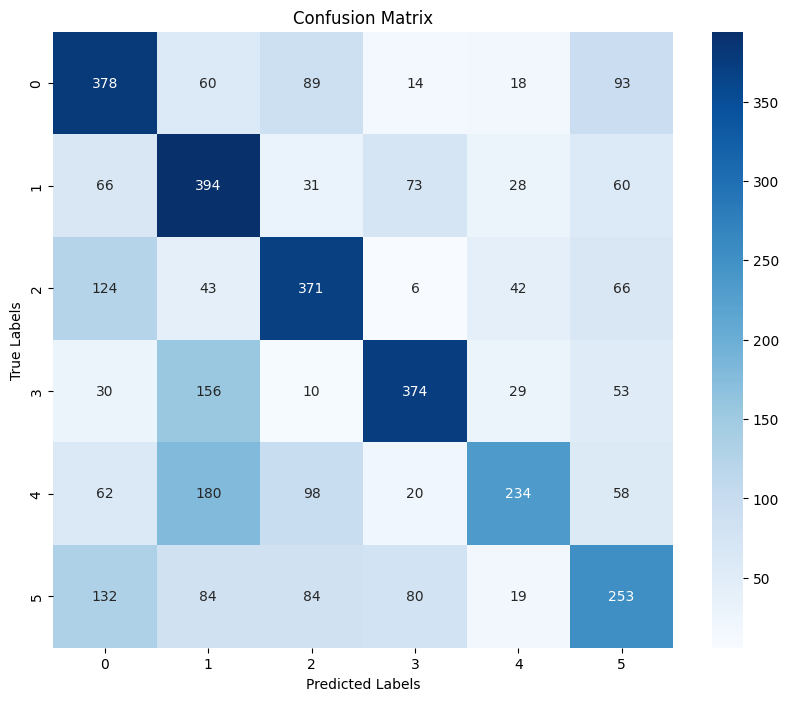

In [5]:
#Version 23 - with augmentation no norm

os.chdir(r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier')

model_path = "Good Models/ModelV2_7_conv_layers_v23.ckpt"
metadata_test_path = 'Data/' + 'test_metadata.npy'
test_hdf5_file_path = 'Data/test_data_no_sur.hdf5'

evaluate_model(model_path,metadata_test_path,test_hdf5_file_path)

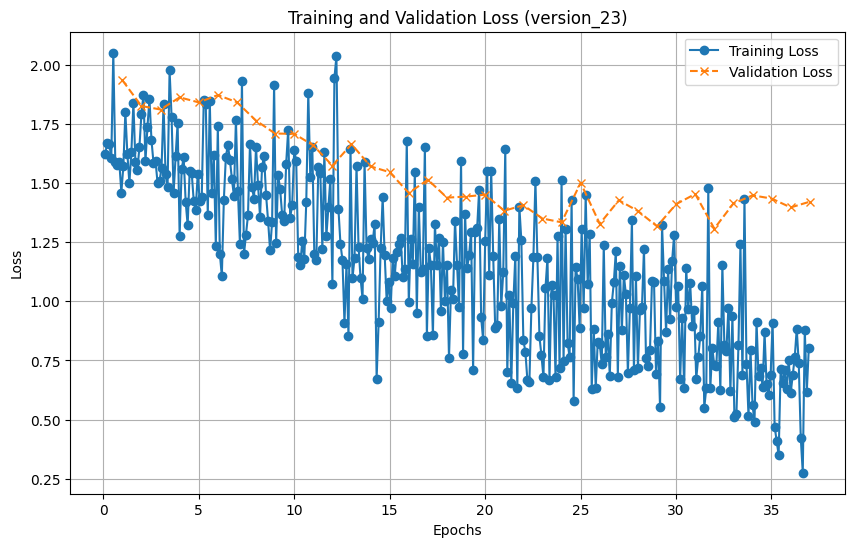

In [6]:
#Version 23

# Training parameters
TRAIN_DATASET_SIZE = get_size_train('Data/training_data_no_sur.hdf5') 

# Define paths and parameters
log_dir_base = r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\logs\emotion_classification'
log_version = 'version_23' 
log_dir = os.path.join(log_dir_base, log_version)

# Extract losses
loss_data = extract_loss_from_logs(
    log_dir=log_dir)

plot_loss_data(loss_data,TRAIN_DATASET_SIZE,log_version)



c:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\Neel Local Code\utilities.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_spec_db = torch.tensor(mel_spec_db).unsqueeze(0).float()


Test Loss: 0.9259
Accuracy: 0.6659
Precision: 0.7011
Recall: 0.6661
F1 Score: 0.6678
['neutral' 'sad' 'disgust' 'angry' 'happy' 'fear']

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     neutral       0.77      0.77      0.77       289
       happy       0.48      0.84      0.61       288
         sad       0.71      0.56      0.63       289
       angry       0.81      0.52      0.63       289
        fear       0.77      0.71      0.74       284
     disgust       0.67      0.60      0.63       288

    accuracy                           0.67      1727
   macro avg       0.70      0.67      0.67      1727
weighted avg       0.70      0.67      0.67      1727



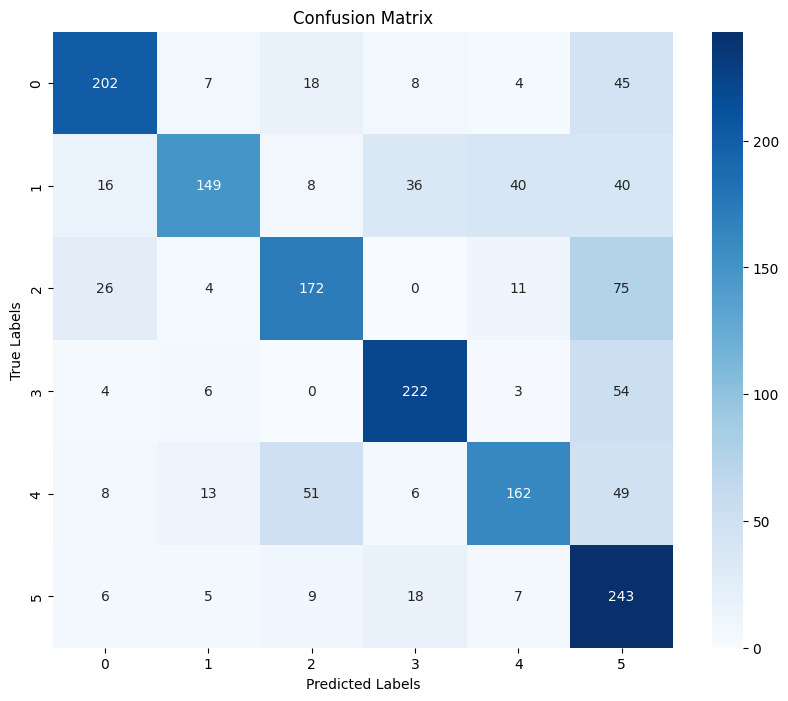

In [7]:
#Version 29 No aug no norm - with resampled to 24414hz
#lr of 1e-3

model_path = "Good Models/Model_no_sur_no_augV1_v29_resampled.ckpt"
metadata_test_path = 'Data/' + 'test_metadata_no_sur_no_aug.npy'
test_hdf5_file_path = 'Data/test_data_no_sur_no_aug.hdf5'

evaluate_model(model_path,metadata_test_path,test_hdf5_file_path)

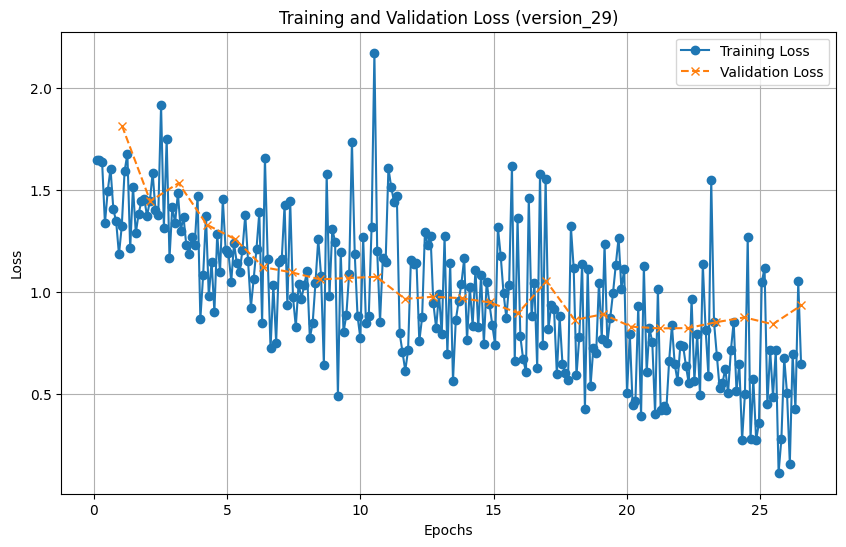

In [8]:
#Version 29

# Training parameters
TRAIN_DATASET_SIZE = get_size_train('Data/training_data_no_sur.hdf5') 

# Define paths and parameters
log_dir_base = r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\logs\emotion_classification'
log_version = 'version_29' 
log_dir = os.path.join(log_dir_base, log_version)

# Extract losses
loss_data = extract_loss_from_logs(
    log_dir=log_dir)

plot_loss_data(loss_data,TRAIN_DATASET_SIZE,log_version)


c:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\Neel Local Code\utilities.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mel_spec_db = torch.tensor(mel_spec_db).unsqueeze(0).float()


Test Loss: 0.9129
Accuracy: 0.6676
Precision: 0.6876
Recall: 0.6680
F1 Score: 0.6638
['neutral' 'sad' 'disgust' 'angry' 'happy' 'fear']

Classification Report:

Classification Report:
              precision    recall  f1-score   support

     neutral       0.75      0.82      0.78       289
       happy       0.79      0.49      0.60       288
         sad       0.75      0.52      0.61       289
       angry       0.69      0.69      0.69       289
        fear       0.58      0.81      0.68       284
     disgust       0.57      0.69      0.62       288

    accuracy                           0.67      1727
   macro avg       0.69      0.67      0.66      1727
weighted avg       0.69      0.67      0.66      1727



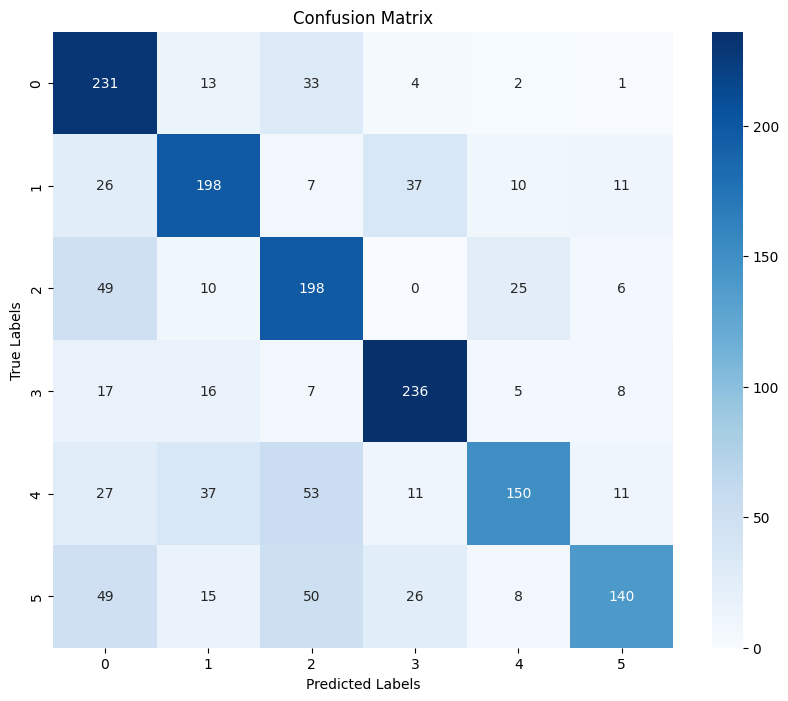

In [9]:

#Version 30 No aug with normalization - with resampled to 24414hz
#lr of 1e-3

model_path = "Good Models/Model_no_sur_no_augV1_v30_resampled_normalized.ckpt"
metadata_test_path = 'Data/' + 'test_metadata_no_sur_no_aug.npy'
test_hdf5_file_path = 'Data/test_data_no_sur_no_aug_normalized.hdf5'

evaluate_model(model_path,metadata_test_path,test_hdf5_file_path)

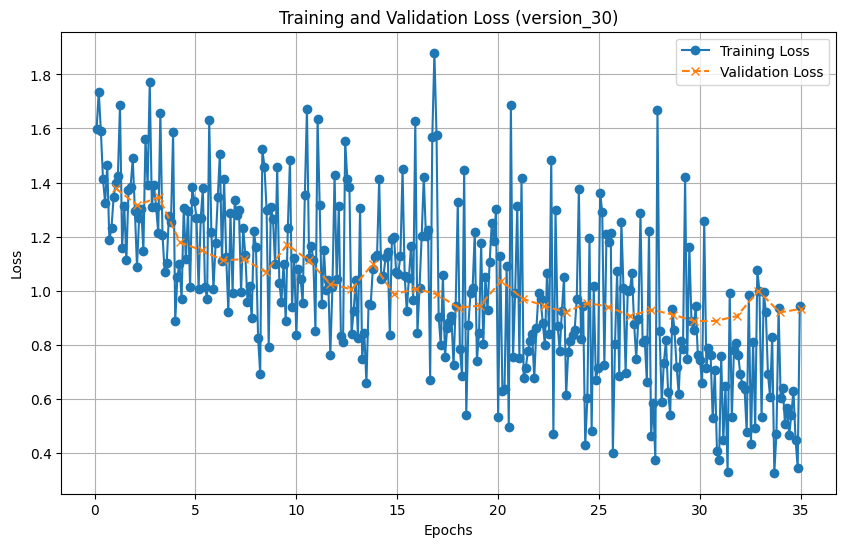

In [10]:
#Version 30

# Training parameters
TRAIN_DATASET_SIZE = get_size_train('Data/training_data_no_sur.hdf5') 

# Define paths and parameters
log_dir_base = r'C:\Users\Neel Patel\Documents\Github Repositories\PytorchAudio_Emotion_Classifier\logs\emotion_classification'
log_version = 'version_30' 
log_dir = os.path.join(log_dir_base, log_version)

# Extract losses
loss_data = extract_loss_from_logs(
    log_dir=log_dir)

plot_loss_data(loss_data,TRAIN_DATASET_SIZE,log_version)
